## Using a Gaussian Process model object

### Introduction

This notebook will demonstrate several features of the `SNModel` class, which stores the model generated from the multidimensional Gaussian Process regression over a collection of transients.

These models by default are saved as `.fits` files and contain several important data products that will be useful to users interested in working with them:

1. `SNModel.surface` -- the model, or "template", of the transient collection. A prediction of the time-evolution of the class's spectral energy distribution at an arbitrary wavelength and phase. It is either an `sklearn` `GaussianProcessRegressor` object or a `numpy` array containing the median SED surface and its IQR.
2. `template_grid` -- a grid of photometry used to normalize the photometry of the collection of objects fit by the GP. This is used to calculate the residuals of the photometry as input to the GPs, and is needed when converting between "observed" photometry and photometric residuals used by the GP.
3. `phase_grid` and `wavelength_grid` -- grids in wavelength and phase space, covering the range of values fit by the GP, with shapes corresponding to the output shape of the `surface` and `template_grid` objects.
4. `sn` or `sn_collection` -- the collection of objects fit by the GP
5. `norm_set` -- the collection of objects used to normalize the photometry

### Setup

Let's import the necessary objects.

In [1]:
from caat import SNModel, SN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from caat.utils import ROOT_DIR
import os
from astropy.time import Time
from scipy.signal import savgol_filter

import logging

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

Configuration file not found:

    /Users/craigpellegrino/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


### 1. Load a saved model object

First let's load a saved GP template object. If a file already exists for an object, providing the filename will automatically load in the saved model object and all other necessary data products.

In [2]:
model = SNModel(
    surface="SESNe_SNIIb_GP_model.fits",
)

The `SNModel` object has a number of useful methods, which we'll demonstrate now.

### 2. Predict a light curve and compare a light curve to observed photometry

One straightforward usage of an `SNModel` object is to use the Gaussian Process regression to predict a light curve. We'll give the object a min and max phase as well as a wavelength (in Angstroms):

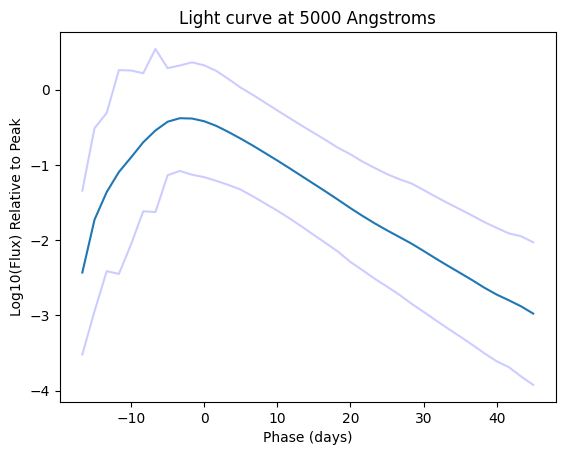

In [3]:
model.predict_lightcurve(-20.0, 45.0, 5000)

The above plot shows a predicted light curve (dark blue line) and the uncertainty in the prediction (light blue lines). We can also see how this prediction stacks up against actual photometry for an object in this class:

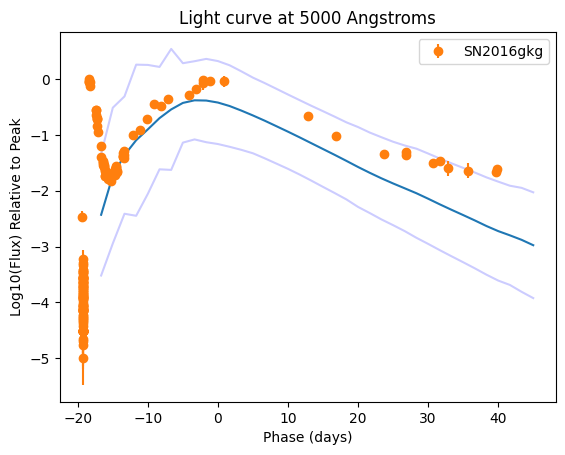

In [4]:
model.predict_lightcurve(-20.0, 45.0, 5000, show=False)
gkg = SN(name="SN2016gkg")
model.compare_lightcurve_with_photometry(gkg, filt="V")

Not bad! This is one of the more peculiar objects in this sample, SN 2016gkg, which has a strong early-time light curve bump due to shock cooling emission. Even so, the photometric evolution is captured within the uncertainty of the GP fairly well, and the rise to the main light curve peak is reproduced.

### 3. Predict an SED and compare an SED to observed spectra

Another basic usage is to predict an SED using a GP model at an arbitrary phase, as this next example shows:

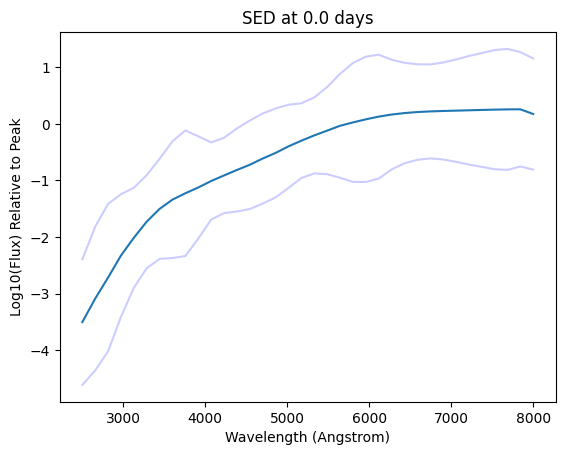

In [5]:
model.predict_sed(
    wavelength_min=2500,
    wavelength_max=8000,
    phase=0.0,
    show=True
)

We can also compare the SED predictions to low resolution spectra.

This isn't an exact comparison since the spectra may not be flux calibrated, so the conversion from flux units to normalized flux isn't exact, but it gives us a rough estimate if the shape of the SED matches observations.

Let's first do this with two spectra of one of the objects in our sample--the SN Icn 2019hgp.

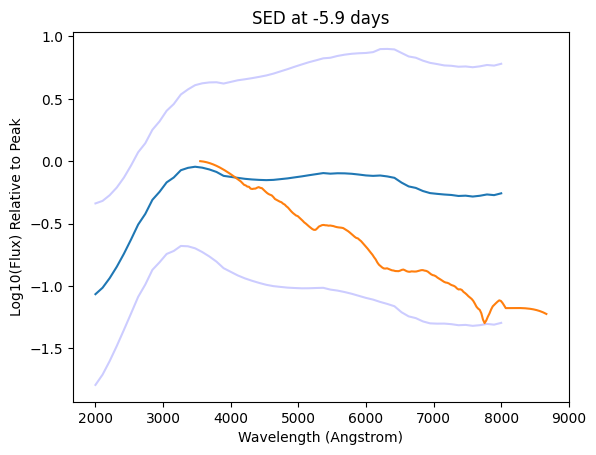

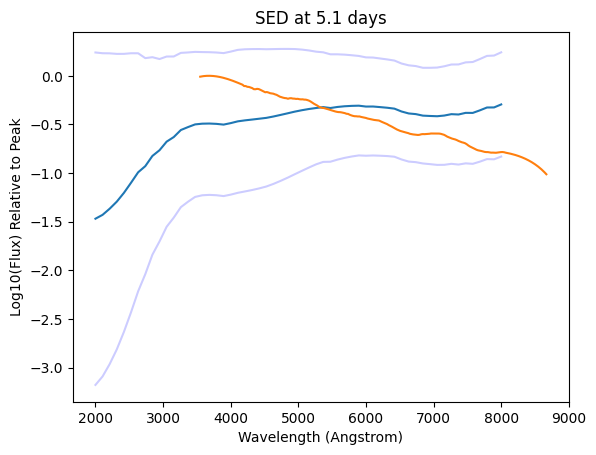

In [6]:
### Load the model

model = SNModel(
    surface="FBOT_SNIcn_GP_model.fits",
)

"""
Compare an SED with a spectrum
Read a saved SEDM spectrum, get the phase of the observation,
and plot the spectrum and predicted SED at that phase
"""

sn = SN(name="SN2019hgp")
for filename in [
    "2019hgp_2019-06-08_03-18-05_P60_SEDM_ZTF.txt",
    "2019hgp_2019-06-19_02-31-11_P60_SEDM_ZTF.txt",
]:
    mjd_of_spec = Time(filename.split('_')[1]).mjd
    phase_of_spec = round(mjd_of_spec - sn.info.get("peak_mjd"), 1)
    spectrum = os.path.join(ROOT_DIR, "data", "spectra", sn.classification, sn.subtype, filename)
    spec_df = pd.read_csv(spectrum, comment="#", names=["Wavelength", "Flux"], delim_whitespace=True)
    model.predict_sed(2000.0, 8000.0, phase_of_spec, show=False)
    ### Smooth the flux to better match the resolution of the SED prediction,
    ### and to remove any artefacts throwing off the fitting
    smooth_flux = savgol_filter(spec_df["Flux"].values, 51, 3)
    norm_flux = smooth_flux / (max(smooth_flux))
    plt.plot(spec_df["Wavelength"].values / (1 + sn.info.get("z", 0.0)), np.log10(norm_flux))
    plt.show()

And here are comparisons between two SNe IIb spectra and the predicted SEDs:

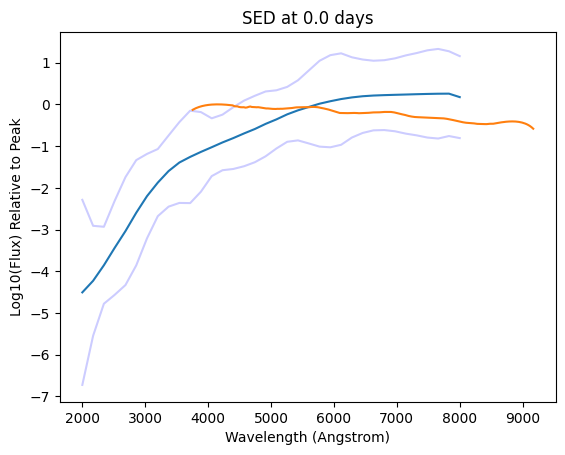

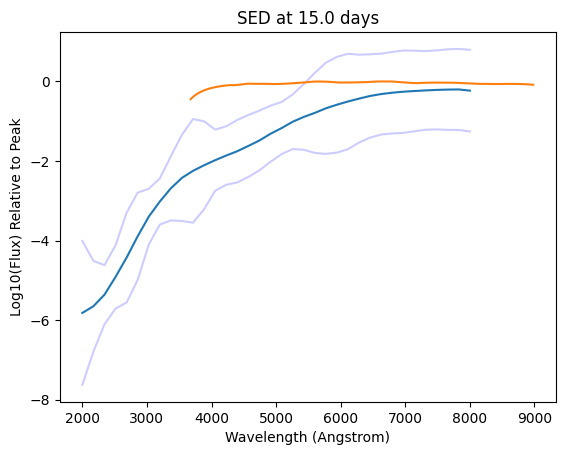

In [7]:
filenames = ["SN2019gaf_2019-06-17_09-00-52_P60_SEDM_TNS.ascii", "SN2020urc_2020-11-10_04-59-42_P60_SEDM_TNS.ascii"]
zs = [0.006, 0.027]
phases = [0.0, 15.0]

model = SNModel(
    surface="SESNe_SNIIb_GP_model.fits"
)

for i, filename in enumerate(filenames):

    spectrum = os.path.join(ROOT_DIR, "data", "spectra", "SESNe", "SNIIb", filename)
    phase_of_spec = phases[i]
    z = zs[i]
    spec_df = pd.read_csv(spectrum, comment="#", delim_whitespace=True, names=["Wavelength", "Flux", "Err"])

    model.predict_sed(2000.0, 8000.0, phase_of_spec, show=False)

    smooth_flux = savgol_filter(spec_df["Flux"].values, 51, 3)
    norm_flux = smooth_flux / max(smooth_flux)
    plt.plot(spec_df["Wavelength"].values / (1 + z), np.log10(norm_flux))

    plt.show()

### 4. Produce synthetic photometry for a class of objects

These GP models can also be used to produce synthetic photometry of a given transient class at an arbitrary phase and wavelength. This is especially useful for constructing training sets at high redshifts to better classify transients discovered by Rubin LSST and Roman. 

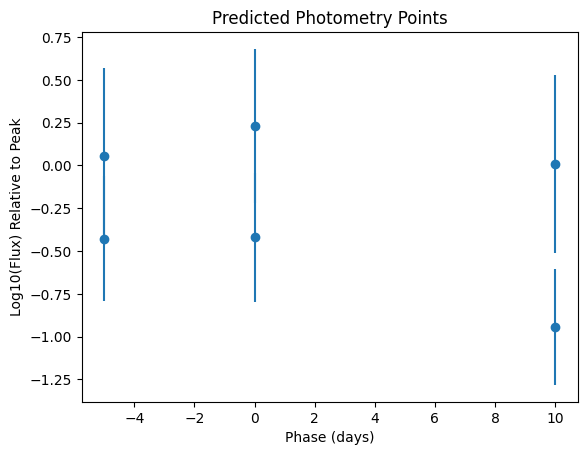

In [8]:
model = SNModel(
    surface="SESNe_SNIIb_GP_model.fits",
)

model.predict_photometry_points(
    wavelengths = np.asarray([5000.0, 5000.0, 5000.0, 7000.0, 7000.0, 7000.0]),
    phases = np.asarray([-5.0, 0.0, 10.0, -5.0, 0.0, 10.0]),
    show=True
)

### 5. Fit input photometry of a new object

Maybe you want to see how well this model performs for new photometry. You can input a dictionary or `pandas` dataframe of photometry and plot a fit, even extrapolated out to phases beyond those covered by the input.

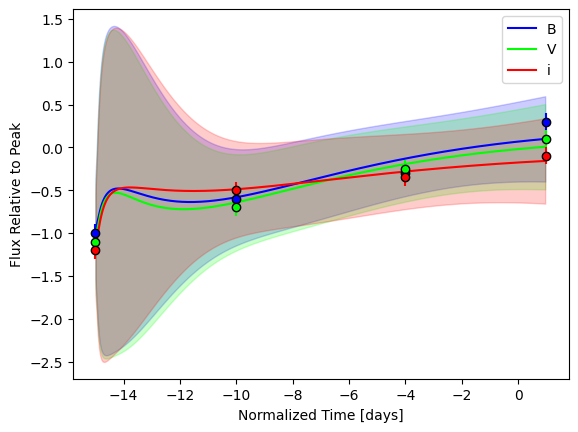

In [9]:
mock_photometry_values = {
    "Filter": ["B", "B", "B", "B", "V", "V", "V", "V", "i", "i", "i", "i"],
    "Phase": [-15.0, -10.0, -4.0, 1.0, -15.0, -10.0, -4.0, 1.0, -15.0, -10.0, -4.0, 1.0],
    "Mag": [-1.0, -0.6, -0.3, 0.3, -1.1, -0.7, -0.25, 0.1, -1.2, -0.5, -0.35, -0.1],
    "MagErr": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
}

model.fit_photometry(
    photometry=mock_photometry_values, 
    show=True
)

Let's run this again, but this time extrapolate the fit out and see how it performs.

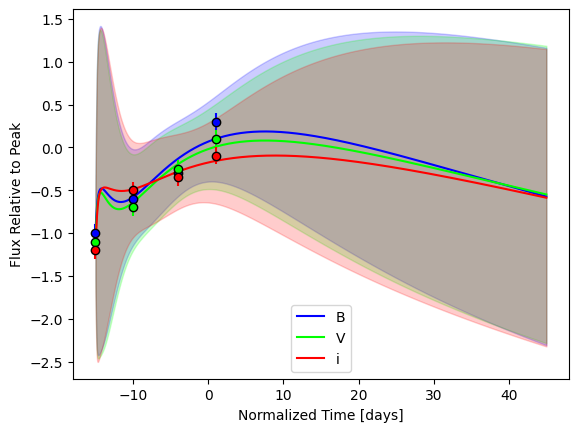

In [10]:
model.fit_photometry(
    photometry=mock_photometry_values, 
    phase_min=-15,
    phase_max=45,
    show=True
)

Or maybe it would be useful to visualize the uncertainty as a series of different light curves, rather than an uncertainty region. We can plot multiple individual fits per filter using the `nsamples` parameter:

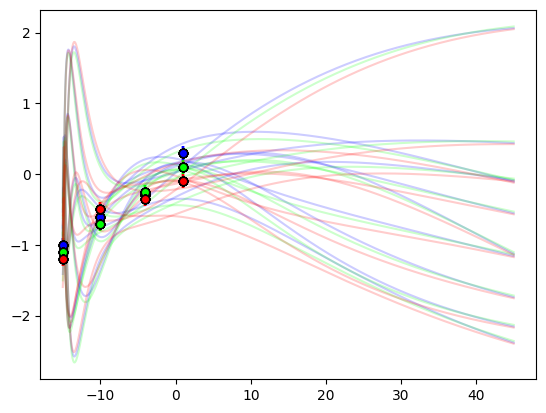

In [11]:
model.fit_photometry(
    photometry=mock_photometry_values, 
    phase_min=-15,
    phase_max=45,
    show=True,
    nsamples=10
)

### Next steps:

These GP model surfaces can be manipulated in a number of ways. The `SNModel` object saves all information needed to generate the underlying `sklearn` `GaussianProcessRegressor` object, which allows for repeated GP fits to new or existing data. The above features are just a sample of what can be done with these novel models.